# 1D Spectral analysis

In this tutorial, we present the basics steps for a 1D spectral analysis. The main aim is to perform a spectral analysis of a point-like source. A spectral analysis consist in stacking all events in the region of interest. Doing this we forget about the spatial information of the source. This is why the 1D analysis is best suited for point-like sources. 

To estimate the background, we will use off regions taken on the data using reflected regions. 

## 1. Crab Nebula

### 1.1 Full containment IRFs: H.E.S.S. data

We are going to analyse the data from the High Energy Stereoscopic System (H.E.S.S.) towards the Crab nebula.  

Let's start with some basic imports:

In [177]:
from gammapy.data import DataStore
from gammapy.maps import MapAxis, RegionGeom, WcsGeom
from gammapy.makers import SpectrumDatasetMaker, ReflectedRegionsBackgroundMaker, SafeMaskMaker, WobbleRegionsFinder
from gammapy.datasets import SpectrumDataset, Datasets
from gammapy.modeling.models import PowerLawSpectralModel, SkyModel, ExpCutoffPowerLawSpectralModel, LogParabolaSpectralModel
from gammapy.modeling import Fit
from gammapy.estimators import FluxPointsEstimator
from gammapy.visualization import plot_spectrum_datasets_off_regions

from astropy.coordinates import SkyCoord
import astropy.units as u
from regions import CircleSkyRegion, PointSkyRegion

import matplotlib.pyplot as plt
import numpy as np

Create a DataStore instance using the following path to H.E.S.S. data: `$GAMMAPY_DATA/hess-dl3-dr1`.

In [178]:
data_store = DataStore.from_dir("$GAMMAPY_DATA/hess-dl3-dr1")

Get the Crab coordinates using astropy `SkyCoord`.

In [188]:
target_position = SkyCoord.from_name("Crab")

To select the relevant runs, we can use the `obs_table` associated to the `DataStore`.

In [180]:
obs_table = data_store.obs_table

Using `select_sky_circle` method of `obs_table`, select run that are at most at 2.2 deg from the Crab Nebula.

In [181]:
obs_table = obs_table.select_sky_circle(target_position, 2.2*u.deg)

We can then get the observations using the `get_observations` method of `DataStore`.

In [182]:
observations = data_store.get_observations(obs_table["OBS_ID"])

In [183]:
print(observations)

Observations
Number of observations: 4
Observation

	obs id            : 23523 
 	tstart            : 53343.92
	tstop             : 53343.94
	duration          : 1687.00 s
	pointing (icrs)   : 83.6 deg, 21.5 deg

	deadtime fraction : 6.2%
Observation

	obs id            : 23526 
 	tstart            : 53343.95
	tstop             : 53343.97
	duration          : 1683.00 s
	pointing (icrs)   : 83.6 deg, 22.5 deg

	deadtime fraction : 6.6%
Observation

	obs id            : 23559 
 	tstart            : 53345.96
	tstop             : 53345.98
	duration          : 1686.00 s
	pointing (icrs)   : 85.3 deg, 22.0 deg

	deadtime fraction : 6.4%
Observation

	obs id            : 23592 
 	tstart            : 53347.91
	tstop             : 53347.93
	duration          : 1686.00 s
	pointing (icrs)   : 82.0 deg, 22.0 deg

	deadtime fraction : 6.2%



Define a energy axis using `MapAxis.from_energy_bounds` between 0.1 and 40 TeV. 

Then define a relevant true energy axis. Remember that the true energy axis should have more bins that the reco energy axis and over a wider range. 

In [184]:
energy_axis = MapAxis.from_energy_bounds(0.1, 40, 10, per_decade=True, unit="TeV")

energy_axis_true = MapAxis.from_energy_bounds(
    0.01, 100, 20, unit="TeV", name="energy_true", per_decade=True
)

Define a region of interest:

In [39]:
on_region = CircleSkyRegion(target_position, 0.1*u.deg)

For the crab, we have to create a exclusion mask. 

In [ ]:
exclusion_region = CircleSkyRegion(
    center=SkyCoord(183.604, -8.708, unit="deg", frame="galactic"),
    radius=0.5 * u.deg,
)

Plot the exclusion mask:

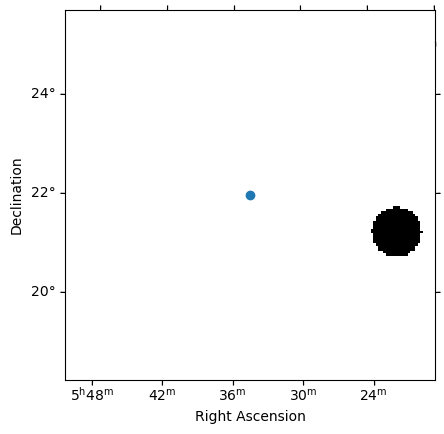

In [198]:
skydir = target_position.galactic
geom = WcsGeom.create(
    npix=(150, 150), binsz=0.05, skydir=skydir, proj="TAN", frame="icrs"
)

exclusion_mask = ~geom.region_mask([exclusion_region])
ax = exclusion_mask.plot()
ax.scatter(target_position.ra, target_position.dec, transform=ax.get_transform("icrs"), label="Crab Nebula")
plt.show()

Create a geometry using `RegionGeom`.

In [ ]:
geom = RegionGeom.create(region=on_region, axes=[energy_axis])

Create an empty `SpectrumDataset`.

In [ ]:
dataset_empty = SpectrumDataset.create(geom=geom, energy_axis_true=energy_axis_true)

Create the Maker instance that we are going to need for the data reduction.

`SpectrumDatasetMaker` will "fill" the dataset with reduces IRFs and counts.

`ReflectedRegionsBackgroundMaker` will get the off counts from reflected regions.

`SafeMaskMaker` will define the safe mask for each dataset.

In [ ]:
dataset_maker = SpectrumDatasetMaker(
    containment_correction=True, selection=["counts", "exposure", "edisp"]
)
bkg_maker = ReflectedRegionsBackgroundMaker(exclusion_mask=exclusion_mask)
safe_mask_maker = SafeMaskMaker(methods=["aeff-max"], aeff_percent=10)

Run the data reduction loop. 

In [42]:
datasets = Datasets()

for obs, obs_id in zip(observations, observations.ids):
    dataset = dataset_maker.run(dataset_empty.copy(name=obs_id), obs)
    dataset_on_off = bkg_maker.run(dataset, obs)
    dataset_on_off = safe_mask_maker.run(dataset_on_off, obs)
    datasets.append(dataset_on_off)

print(datasets)

Datasets
--------

Dataset 0: 

  Type       : SpectrumDatasetOnOff
  Name       : 23523
  Instrument : HESS
  Models     : 

Dataset 1: 

  Type       : SpectrumDatasetOnOff
  Name       : 23526
  Instrument : HESS
  Models     : 

Dataset 2: 

  Type       : SpectrumDatasetOnOff
  Name       : 23559
  Instrument : HESS
  Models     : 

Dataset 3: 

  Type       : SpectrumDatasetOnOff
  Name       : 23592
  Instrument : HESS
  Models     : 




Info table:

In [43]:
info_table = datasets.info_table(cumulative=True)

In [44]:
info_table

name,counts,excess,sqrt_ts,background,npred,npred_background,npred_signal,exposure_min,exposure_max,livetime,ontime,counts_rate,background_rate,excess_rate,n_bins,n_fit_bins,stat_type,stat_sum,counts_off,acceptance,acceptance_off,alpha
,,,,,,,,m2 s,m2 s,s,s,1 / s,1 / s,1 / s,,,,,,,,
str7,int64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,int64,int64,str5,float64,int64,float64,float64,float64
stacked,138,129.64285278320312,20.292670756437655,8.35714340209961,17.00000070929527,17.00000070929527,nan,261125.234375,812781824.0,1581.736764695497,1687.0000000000016,0.08724586990716286,0.005283523522138311,0.08196234397331019,27,18,wstat,429.14752802630784,117,18.0,251.99998474121094,0.0714285746216774
stacked,278,259.78570556640625,28.336551725200557,18.21428680419922,35.53333481589952,35.53333481589952,nan,1219494.25,1525205120.0,3154.4235137812757,3369.9999999999964,0.0881302078764799,0.005774204612862956,0.0823560008449834,27,19,wstat,816.8062547635578,255,19.0,266.0,0.0714285746216774
stacked,406,381.1987609863281,36.05074858609181,24.80124282836914,41.60576037780791,41.60576037780791,nan,1746170.375,2010911488.0,4732.546993609518,5056.000000000001,0.08578889983516962,0.0052405697950509336,0.08054833084617455,27,19,wstat,1316.932244361559,558,19.0,427.47857666015625,0.0444466732442379
stacked,509,477.9679870605469,40.72510616549709,31.032012939453125,49.173435297609366,49.173435297609366,nan,1906861.875,2551171840.0,6313.811659421768,6741.999999999996,0.08061691216912467,0.004914941181868434,0.07570197098725624,27,19,wstat,1688.3443102128654,801,19.0,490.4290466308594,0.0387415885925293


Plot the reflected regions:

/Users/mregeard/anaconda3/envs/gammapy-1.2/lib/python3.10/site-packages/regions/shapes/circle.py:161: UserWarning: Setting the 'color' property will override the edgecolor or facecolor properties.
  return Circle(xy=xy, radius=radius, **mpl_kwargs)
/Users/mregeard/anaconda3/envs/gammapy-1.2/lib/python3.10/site-packages/gammapy/visualization/datasets.py:84: UserWarning: Setting the 'color' property will override the edgecolor or facecolor properties.
  handle = Patch(**plot_kwargs)


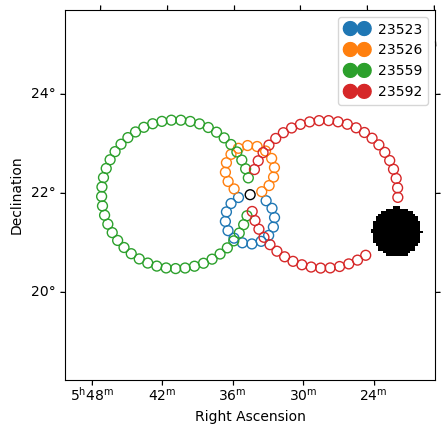

In [45]:
plt.figure()
ax = exclusion_mask.plot()
on_region.to_pixel(ax.wcs).plot(ax=ax, edgecolor="k")
plot_spectrum_datasets_off_regions(ax=ax, datasets=datasets)
plt.show()

Stack the dataset using `stack_reduce`.

In [46]:
stacked = datasets.stack_reduce(name="stacked")

Create a power-law using the `PowerLawSpectralModel`.

In [47]:
spectral_model = PowerLawSpectralModel(
    index=2, 
    amplitude=2e-11 * u.Unit("cm-2 s-1 TeV-1"), 
    reference=1*u.TeV
)

Create a `SkyModel`.

In [48]:
sky_model = SkyModel(spectral_model=spectral_model, name="Crab")

Fit the model to the stacked dataset.

In [49]:
stacked.models = sky_model

In [50]:
fit = Fit()
result = fit.run(datasets=stacked)

In [51]:
print(result)

OptimizeResult

	backend    : minuit
	method     : migrad
	success    : True
	message    : Optimization terminated successfully.
	nfev       : 47
	total stat : 14.13

CovarianceResult

	backend    : minuit
	method     : hesse
	success    : True
	message    : Hesse terminated successfully.



In [52]:
stacked.models

Print the residuals:

<Axes: xlabel='Energy [$\\mathrm{TeV}$]', ylabel='Residuals ((data - model) / sqrt(model))'>

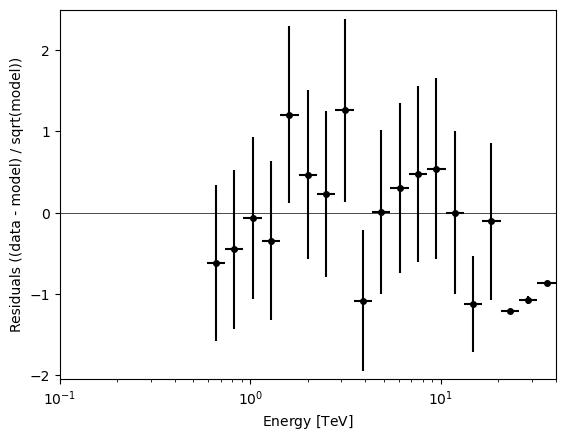

In [53]:
stacked.plot_residuals_spectral(method="diff/sqrt(model)")

Extract flux points:

In [54]:
fp = FluxPointsEstimator(
     energy_edges=energy_axis.edges, 
    source="Crab", 
    selection_optional="all"
).run(datasets=stacked)

Plot the model and flux points.

<Axes: xlabel='Energy [$\\mathrm{TeV}$]', ylabel='e2dnde [$\\mathrm{erg\\,s^{-1}\\,cm^{-2}}$]'>

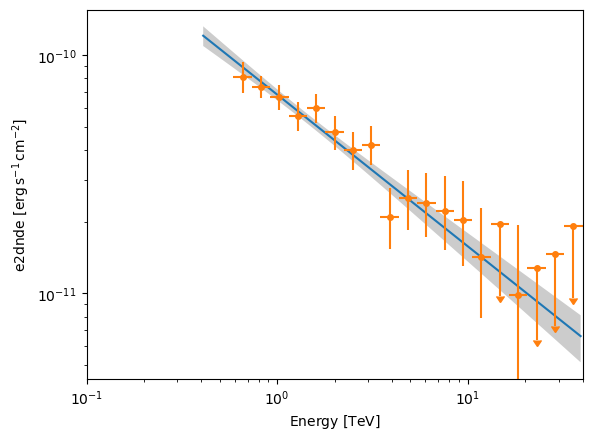

In [55]:
sed_type = "e2dnde"
energy_bounds = [0.4, 40]*u.TeV

stacked.models[0].spectral_model.plot(energy_bounds=energy_bounds, sed_type=sed_type, label="Best fit")
stacked.models[0].spectral_model.plot_error(energy_bounds=energy_bounds, sed_type=sed_type)
fp.plot(sed_type=sed_type, label="Flux Points")

#### Model significance

Exercise: Is a power-law the best model to describe the data ? 

To answer this question, we propose to use a likelihood ratio test (see Jonathan lecture) test both a `LogParabolaSpectralModel` and an `ExpCutoffPowerLawSpectralModel`.

Are those two models nested models to a power-law respectively ?

Can we apply Wilk's theorem ? 

Knowing that the "total stat" of the fit result is $-2\ln(\mathcal{L})$, where $\mathcal{L}$ is the likelihood, compute the significance of the exponentially cutoff power-law and the log-parabola against the power-law. 

Can you do the same likelihood ratio test to distinguish the exponentially cutoff power-law and the log-parabola ?

In [56]:
spectral_model_exp = ExpCutoffPowerLawSpectralModel(
    index=2, 
    amplitude=2e-11 * u.Unit("cm-2 s-1 TeV-1"), 
    reference=1*u.TeV,
    lambda_ = (1/10)/u.TeV,
)

In [57]:
sky_model_exp = SkyModel(spectral_model=spectral_model_exp, name="Crab exp")

In [58]:
stacked.models = sky_model_exp

In [59]:
fit = Fit()
result_exp = fit.run(datasets=stacked)

In [60]:
print(result_exp)

OptimizeResult

	backend    : minuit
	method     : migrad
	success    : True
	message    : Optimization terminated successfully.
	nfev       : 94
	total stat : 8.28

CovarianceResult

	backend    : minuit
	method     : hesse
	success    : True
	message    : Hesse terminated successfully.



In [61]:
stacked.models

<Axes: xlabel='Energy [$\\mathrm{TeV}$]', ylabel='Residuals ((data - model) / sqrt(model))'>

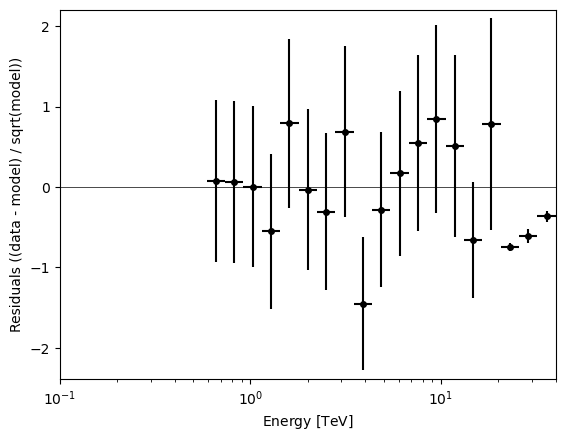

In [62]:
stacked.plot_residuals_spectral(method="diff/sqrt(model)")

In [64]:
h0 = result.optimize_result.total_stat
h1 = result_exp.optimize_result.total_stat
likelihood_ratio_ts = -(h1 - h0)

In [65]:
np.sqrt(likelihood_ratio_ts)

2.4181040416882174

In [66]:
fp_exp = FluxPointsEstimator(
     energy_edges=energy_axis.edges, 
    source="Crab exp", 
    selection_optional="all"
).run(datasets=stacked)

(0.4, 40)

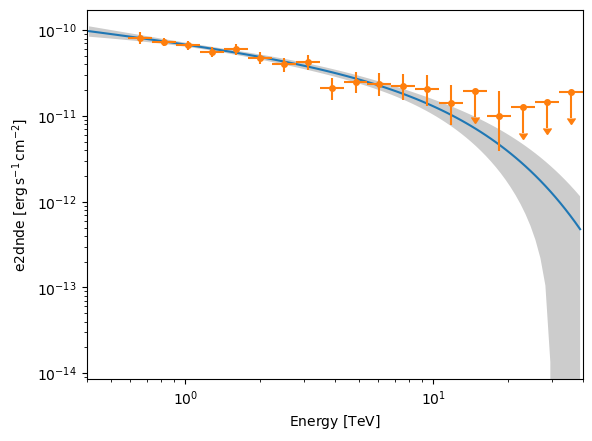

In [68]:
sed_type = "e2dnde"
energy_bounds = [0.4, 40]*u.TeV

stacked.models[0].spectral_model.plot(energy_bounds=energy_bounds, sed_type=sed_type, label="Best fit")
stacked.models[0].spectral_model.plot_error(energy_bounds=energy_bounds, sed_type=sed_type)
fp.plot(sed_type=sed_type, label="Flux Points")

plt.xlim(0.4, 40)

In [70]:
spectral_model_log = LogParabolaSpectralModel(
    alpha=2, 
    amplitude=2e-11 * u.Unit("cm-2 s-1 TeV-1"), 
    reference=1*u.TeV,
    beta=1,
)

In [71]:
sky_model_log = SkyModel(spectral_model=spectral_model_log, name="Crab log")

In [72]:
stacked.models = sky_model_log

In [74]:
fit = Fit()
result_log = fit.run(datasets=stacked)

In [75]:
print(result_exp)

OptimizeResult

	backend    : minuit
	method     : migrad
	success    : True
	message    : Optimization terminated successfully.
	nfev       : 141
	total stat : 9.52

CovarianceResult

	backend    : minuit
	method     : hesse
	success    : True
	message    : Hesse terminated successfully.



In [76]:
stacked.models

<Axes: xlabel='Energy [$\\mathrm{TeV}$]', ylabel='Residuals ((data - model) / sqrt(model))'>

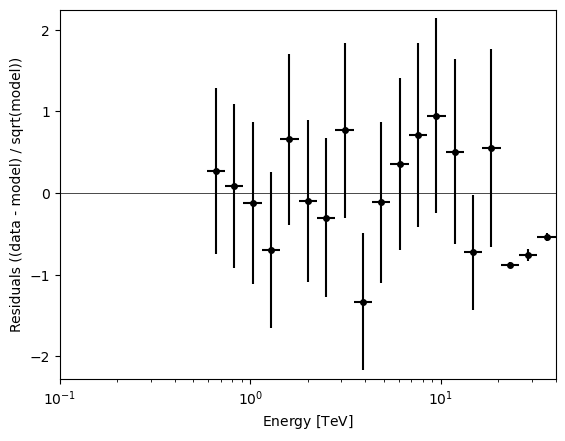

In [77]:
stacked.plot_residuals_spectral(method="diff/sqrt(model)")

In [78]:
h0 = result.optimize_result.total_stat
h1 = result_log.optimize_result.total_stat
likelihood_ratio_ts = -(h1 - h0)

In [79]:
np.sqrt(likelihood_ratio_ts)

2.147316860168191

In [81]:
fp_log = FluxPointsEstimator(
     energy_edges=energy_axis.edges, 
    source="Crab log", 
    selection_optional="all"
).run(datasets=stacked)

(0.4, 40)

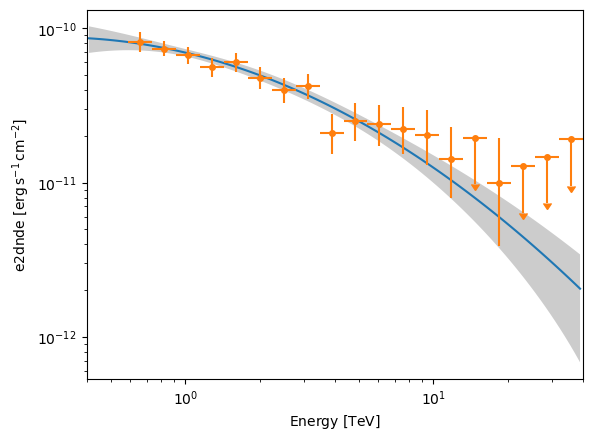

In [82]:
sed_type = "e2dnde"
energy_bounds = [0.4, 40]*u.TeV

stacked.models[0].spectral_model.plot(energy_bounds=energy_bounds, sed_type=sed_type, label="Best fit")
stacked.models[0].spectral_model.plot_error(energy_bounds=energy_bounds, sed_type=sed_type)
fp.plot(sed_type=sed_type, label="Flux Points")

plt.xlim(0.4, 40)

### 1.2 Point-like IRFs

#### Redo the Crab nebulae analysis using "Point-like" observations from MAGIC

For that you will have to get the data from `$GAMMAPY_DATA/magic/rad_max/data/`. 

To get the observations, `required_irf="point-like"` has to be passed to `DataStore.get_observations`.

Also note that MAGIC energy threshold is lower that H.E.S.S.. You can start your dataset reco energy axis at 50 GeV. Of course, you will have to adapt you true energy in consequences.

Finally, using "point-like" IRFs, it is better to use Wobble regions for the off counts. You can define region_finder of `ReflectedRegionsBackgroundMaker` to `ReflectedRegionsBackgroundMaker`. 

In [158]:
data_store = DataStore.from_dir("$GAMMAPY_DATA/magic/rad_max/data/")

In [159]:
observations = data_store.get_observations(required_irf="point-like")

In [160]:
on_region = PointSkyRegion(target_position)

In [161]:
energy_axis = MapAxis.from_energy_bounds(
    40, 2e4, nbin=5, per_decade=True, unit="GeV", name="energy"
)
energy_axis_true = MapAxis.from_energy_bounds(
    10, 1e5, nbin=10, per_decade=True, unit="GeV", name="energy_true"
)

In [162]:
geom = RegionGeom.create(region=on_region, axes=[energy_axis])

dataset_empty = SpectrumDataset.create(geom=geom, energy_axis_true=energy_axis_true)

dataset_maker = SpectrumDatasetMaker(
    selection=["counts", "exposure", "edisp"]
)

off_region_finder = ReflectedRegionsBackgroundMaker(n_off_regions=3)
bkg_maker = ReflectedRegionsBackgroundMaker(region_finder=off_region_finder, exclusion_mask=exclusion_mask)
safe_mask_maker = SafeMaskMaker(methods=["aeff-max"], aeff_percent=10)

In [163]:
datasets = Datasets()

for obs, obs_id in zip(observations, observations.ids):
    dataset = dataset_maker.run(dataset_empty.copy(name=obs_id), obs)
    dataset_on_off = bkg_maker.run(dataset, obs)
    dataset_on_off = safe_mask_maker.run(dataset_on_off, obs)
    datasets.append(dataset_on_off)

print(datasets)

'THETA' axis is stored as a scalar -- converting to 1D array.
'THETA' axis is stored as a scalar -- converting to 1D array.
'THETA' axis is stored as a scalar -- converting to 1D array.
'THETA' axis is stored as a scalar -- converting to 1D array.
'THETA' axis is stored as a scalar -- converting to 1D array.
'THETA' axis is stored as a scalar -- converting to 1D array.
'THETA' axis is stored as a scalar -- converting to 1D array.
'THETA' axis is stored as a scalar -- converting to 1D array.
'THETA' axis is stored as a scalar -- converting to 1D array.
'THETA' axis is stored as a scalar -- converting to 1D array.
'THETA' axis is stored as a scalar -- converting to 1D array.
'THETA' axis is stored as a scalar -- converting to 1D array.
'THETA' axis is stored as a scalar -- converting to 1D array.
'THETA' axis is stored as a scalar -- converting to 1D array.


Datasets
--------

Dataset 0: 

  Type       : SpectrumDatasetOnOff
  Name       : 5029747
  Instrument : Unknown
  Models     : 

Dataset 1: 

  Type       : SpectrumDatasetOnOff
  Name       : 5029748
  Instrument : Unknown
  Models     : 




In [164]:
stacked = datasets.stack_reduce(name="stacked")

/Users/mregeard/anaconda3/envs/gammapy-1.2/lib/python3.10/site-packages/gammapy/visualization/datasets.py:84: UserWarning: Setting the 'color' property will override the edgecolor or facecolor properties.
  handle = Patch(**plot_kwargs)


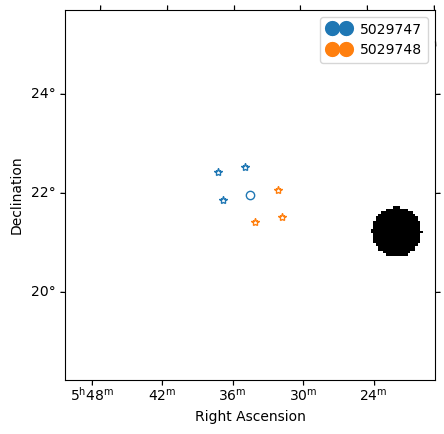

In [165]:
plt.figure()
ax = exclusion_mask.plot()
on_region.to_pixel(ax.wcs).plot(ax=ax)
plot_spectrum_datasets_off_regions(ax=ax, datasets=datasets)
plt.show()

In [166]:
spectral_model_exp = ExpCutoffPowerLawSpectralModel(
    index=2, 
    amplitude=2e-11 * u.Unit("cm-2 s-1 TeV-1"), 
    reference=1*u.TeV,
    lambda_ = (1/10)/u.TeV,
)

In [167]:
sky_model_exp = SkyModel(spectral_model=spectral_model_exp, name="Crab exp")

In [168]:
stacked.models = sky_model_exp

In [126]:
for d in datasets:
    d.mask_fit = dataset.counts.geom.energy_mask(20*u.GeV, 20*u.TeV)

In [169]:
fit = Fit()
result_exp = fit.run(datasets=stacked)

In [170]:
print(result_exp)

OptimizeResult

	backend    : minuit
	method     : migrad
	success    : True
	message    : Optimization terminated successfully.
	nfev       : 154
	total stat : 7.39

CovarianceResult

	backend    : minuit
	method     : hesse
	success    : True
	message    : Hesse terminated successfully.



In [171]:
print(stacked.models)

DatasetModels

Component 0: SkyModel

  Name                      : Crab exp
  Datasets names            : None
  Spectral model type       : ExpCutoffPowerLawSpectralModel
  Spatial  model type       : 
  Temporal model type       : 
  Parameters:
    index                         :      2.012   +/-    0.10             
    amplitude                     :   6.63e-11   +/- 1.2e-11 1 / (TeV s cm2)
    reference             (frozen):      1.000       TeV         
    lambda_                       :      0.360   +/-    0.14 1 / TeV     
    alpha                 (frozen):      1.000                   




<Axes: xlabel='Energy [$\\mathrm{GeV}$]', ylabel='Residuals ((data - model) / sqrt(model))'>

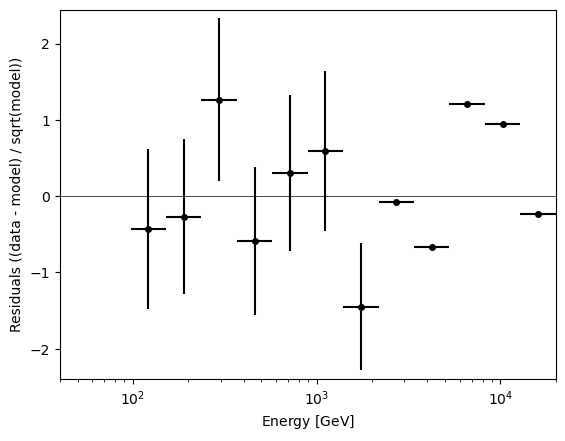

In [172]:
stacked.plot_residuals_spectral(method="diff/sqrt(model)")

In [173]:
fp_exp = FluxPointsEstimator(
     energy_edges=energy_axis.edges, 
    source="Crab exp", 
    selection_optional="all"
).run(datasets=stacked)

(2e-12, 2e-10)

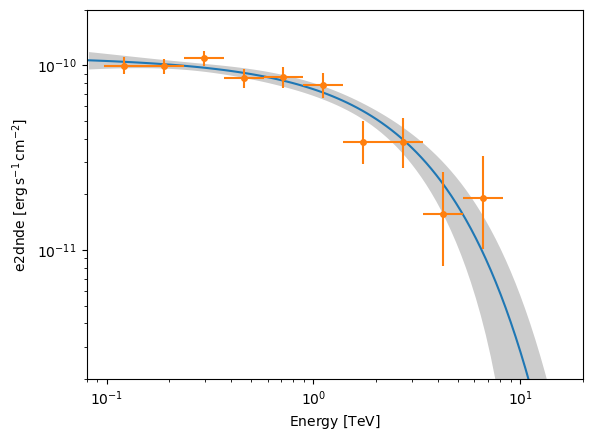

In [174]:
sed_type = "e2dnde"
energy_bounds = [0.08, 20]*u.TeV

stacked.models[0].spectral_model.plot(energy_bounds=energy_bounds, sed_type=sed_type, label="Best fit")
stacked.models[0].spectral_model.plot_error(energy_bounds=energy_bounds, sed_type=sed_type)
fp_exp.plot(sed_type=sed_type, label="Flux Points")

plt.xlim(0.08, 20)
plt.ylim(2e-12, 2e-10)

## Open problem: RX J1713.7-3946 1D

This morning we did the analysis of `RX J1713.7-3946` using the 3D anamysis. Do the same analysis with the using a spectral analisys.

Questions to ask yourself: 
 - What is the size of the region of interest for this source ?
 - Do you need an exclusion mask ?
 - Is your off regions correctly measured ?
 - Conclude !

In [4]:
target_position = SkyCoord.from_name("RX J1713.7-3946")

In [5]:
obs_table = data_store.obs_table

In [8]:
obs_table = obs_table.select_sky_circle(target_position, 2.2*u.deg)

In [10]:
observations = data_store.get_observations(obs_table["OBS_ID"])

In [11]:
print(observations)

Observations
Number of observations: 15
Observation

	obs id            : 20326 
 	tstart            : 53112.06
	tstop             : 53112.08
	duration          : 1683.00 s
	pointing (icrs)   : 259.3 deg, -39.8 deg

	deadtime fraction : 10.9%
Observation

	obs id            : 20327 
 	tstart            : 53112.09
	tstop             : 53112.10
	duration          : 1683.00 s
	pointing (icrs)   : 257.5 deg, -39.8 deg

	deadtime fraction : 11.0%
Observation

	obs id            : 20349 
 	tstart            : 53113.10
	tstop             : 53113.12
	duration          : 1682.00 s
	pointing (icrs)   : 259.3 deg, -39.8 deg

	deadtime fraction : 11.1%
Observation

	obs id            : 20350 
 	tstart            : 53113.12
	tstop             : 53113.14
	duration          : 1682.00 s
	pointing (icrs)   : 257.5 deg, -39.8 deg

	deadtime fraction : 11.0%
Observation

	obs id            : 20396 
 	tstart            : 53115.10
	tstop             : 53115.12
	duration          : 1683.00 s
	pointing (icrs

In [89]:
energy_axis = MapAxis.from_energy_bounds(0.3, 10.0, 15, unit="TeV")

energy_axis_true = MapAxis.from_energy_bounds(
    0.1, 20, 20, unit="TeV", name="energy_true"
)

In [121]:
on_region = CircleSkyRegion(target_position, 0.5*u.deg)

In [122]:
geom = RegionGeom.create(region=on_region, axes=[energy_axis])

dataset_empty = SpectrumDataset.create(geom=geom, energy_axis_true=energy_axis_true)

dataset_maker = SpectrumDatasetMaker(
    containment_correction=True, selection=["counts", "exposure", "edisp"]
)
bkg_maker = ReflectedRegionsBackgroundMaker()
safe_mask_maker = SafeMaskMaker(methods=["aeff-max"], aeff_percent=10)

In [123]:
datasets = Datasets()

for obs, obs_id in zip(observations, observations.ids):
    dataset = dataset_maker.run(dataset_empty.copy(name=obs_id), obs)
    dataset_on_off = bkg_maker.run(dataset, obs)
    dataset_on_off = safe_mask_maker.run(dataset_on_off, obs)
    datasets.append(dataset_on_off)

print(datasets)

ReflectedRegionsBackgroundMaker failed. No OFF region found outside exclusion mask for dataset '20327'.
ReflectedRegionsBackgroundMaker failed. Setting 20327 mask to False.
ReflectedRegionsBackgroundMaker failed. No OFF region found outside exclusion mask for dataset '20350'.
ReflectedRegionsBackgroundMaker failed. Setting 20350 mask to False.
ReflectedRegionsBackgroundMaker failed. No OFF region found outside exclusion mask for dataset '20517'.
ReflectedRegionsBackgroundMaker failed. Setting 20517 mask to False.


Datasets
--------

Dataset 0: 

  Type       : SpectrumDatasetOnOff
  Name       : 20326
  Instrument : HESS
  Models     : 

Dataset 1: 

  Type       : SpectrumDatasetOnOff
  Name       : 20327
  Instrument : HESS
  Models     : 

Dataset 2: 

  Type       : SpectrumDatasetOnOff
  Name       : 20349
  Instrument : HESS
  Models     : 

Dataset 3: 

  Type       : SpectrumDatasetOnOff
  Name       : 20350
  Instrument : HESS
  Models     : 

Dataset 4: 

  Type       : SpectrumDatasetOnOff
  Name       : 20396
  Instrument : HESS
  Models     : 

Dataset 5: 

  Type       : SpectrumDatasetOnOff
  Name       : 20397
  Instrument : HESS
  Models     : 

Dataset 6: 

  Type       : SpectrumDatasetOnOff
  Name       : 20421
  Instrument : HESS
  Models     : 

Dataset 7: 

  Type       : SpectrumDatasetOnOff
  Name       : 20422
  Instrument : HESS
  Models     : 

Dataset 8: 

  Type       : SpectrumDatasetOnOff
  Name       : 20517
  Instrument : HESS
  Models     : 

Dataset 9: 

  Typ

In [109]:
info_table = datasets.info_table(cumulative=True)

In [110]:
info_table

name,counts,excess,sqrt_ts,background,npred,npred_background,npred_signal,exposure_min,exposure_max,livetime,ontime,counts_rate,background_rate,excess_rate,n_bins,n_fit_bins,stat_type,stat_sum,counts_off,acceptance,acceptance_off,alpha
,,,,,,,,m2 s,m2 s,s,s,1 / s,1 / s,1 / s,,,,,,,,
str7,int64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,int64,int64,str5,float64,int64,float64,float64,float64
stacked,284,87.0,5.244584308638844,197.0,211.5000026263296,211.5000026263296,nan,2708968.5,406447520.0,1500.0090973600734,1682.9999999999993,0.18933218505129273,0.13133253681374885,0.0579996482375439,15,15,wstat,64.25380759420034,985,15.0,75.0,0.20000000298023224
stacked,561,159.50003051757812,6.523570945824667,401.5,437.50317795020584,437.50317795020584,nan,9502705.0,821627136.0,2997.083039179447,3366.0000000000036,0.1871820008542682,0.13396358884668214,0.05321842219001268,15,15,wstat,81.0130285977751,1394,15.0,52.07970428466797,0.2880200743675232
stacked,836,250.0999755859375,8.555740965863928,585.9000244140625,636.7755657548679,636.7755657548679,nan,16034038.0,1213393664.0,4491.585450589662,5048.0000000000055,0.1861258144137609,0.13044392249893513,0.055681891914825754,15,15,wstat,124.03276720305195,2316,15.0,59.293392181396484,0.2529792785644531
stacked,1128,302.5999755859375,8.649200261436464,825.4000244140625,895.1404782635358,895.1404782635358,nan,18965860.0,1643384320.0,5989.239929720767,6730.000000000007,0.18833775457925095,0.13781381846436477,0.050523936114886196,15,15,wstat,130.99487938592935,2795,15.0,50.793556213378906,0.2953130602836609
stacked,1434,408.2667236328125,10.384220673848745,1025.7332763671875,1120.9762480078368,1120.9762480078368,nan,25291306.0,2053247744.0,7488.240902796398,8413.000000000011,0.19150024933953302,0.1369792037518637,0.05452104558766933,15,15,wstat,168.87022056558033,3396,15.0,49.66203308105469,0.30204159021377563
stacked,1712,465.266845703125,10.82706735176097,1246.733154296875,1352.4109361711821,1352.4109361711821,nan,26905694.0,2468439296.0,8993.412239596255,10095.00000000001,0.1903615618177042,0.1386273775828656,0.05173418423483859,15,15,wstat,190.13945329732115,4280,15.0,51.49457931518555,0.29129278659820557
stacked,2006,558.5169677734375,12.070093410866294,1447.483154296875,1571.8948808216555,1571.8948808216555,nan,33063228.0,2870104064.0,10494.478251762695,11778.00000000001,0.19114814018153442,0.13792807222729248,0.053220079586102975,15,15,wstat,233.48050156350675,5083,15.0,52.674190521240234,0.2847694456577301
stacked,2323,654.183349609375,13.12213207769551,1668.8165283203125,1816.6963421138541,1816.6963421138541,nan,34400648.0,3295418624.0,11997.819687850784,13461.000000000015,0.1936185123995748,0.13909331626396979,0.05452518596123038,15,15,wstat,269.9516467201377,5747,15.0,51.65636444091797,0.29038047790527344


In [111]:
stacked = datasets.stack_reduce(name="stacked")

In [112]:
spectral_model = PowerLawSpectralModel(
    index=2, 
    amplitude=2e-11 * u.Unit("cm-2 s-1 TeV-1"), 
    reference=1*u.TeV
)

In [113]:
sky_model = SkyModel(spectral_model=spectral_model, name="RX")

In [114]:
stacked.models = [sky_model]

In [115]:
fit = Fit()
result = fit.run(datasets=stacked)

In [116]:
print(result)

OptimizeResult

	backend    : minuit
	method     : migrad
	success    : True
	message    : Optimization terminated successfully.
	nfev       : 43
	total stat : 18.19

CovarianceResult

	backend    : minuit
	method     : hesse
	success    : True
	message    : Hesse terminated successfully.



In [117]:
print(stacked)

SpectrumDatasetOnOff
--------------------

  Name                            : stacked 

  Total counts                    : 4136 
  Total background counts         : 2867.73
  Total excess counts             : 1268.27

  Predicted counts                : 4130.50
  Predicted background counts     : 2868.96
  Predicted excess counts         : 1261.55

  Exposure min                    : 4.96e+07 m2 s
  Exposure max                    : 5.87e+09 m2 s

  Number of total bins            : 15 
  Number of fit bins              : 15 

  Fit statistic type              : wstat
  Fit statistic value (-2 log(L)) : 18.19

  Number of models                : 1 
  Number of parameters            : 3
  Number of free parameters       : 2

  Component 0: SkyModel
  
    Name                      : RX
    Datasets names            : None
    Spectral model type       : PowerLawSpectralModel
    Spatial  model type       : 
    Temporal model type       : 
    Parameters:
      index                  

<Axes: xlabel='Energy [$\\mathrm{TeV}$]', ylabel='e2dnde [$\\mathrm{erg\\,s^{-1}\\,cm^{-2}}$]'>

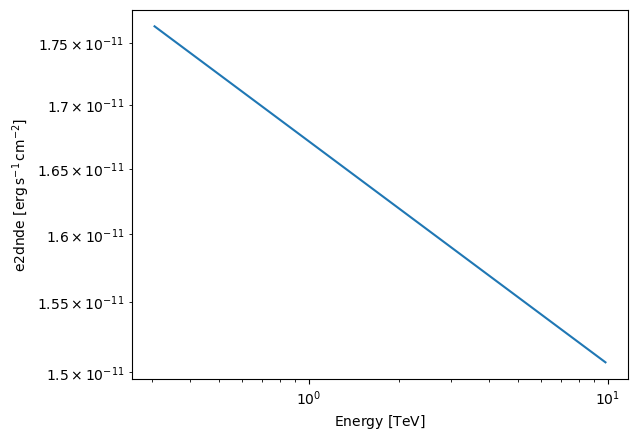

In [118]:
stacked.models[0].spectral_model.plot(energy_bounds=[0.3, 10]*u.TeV, sed_type="e2dnde")

In [119]:
spectral_model_3d = PowerLawSpectralModel(
    index=1.913,
    amplitude="2.30e-11 TeV-1 cm-2 s-1",
    reference="1 TeV",
)
spectral_model_3d.index.error = 0.04
spectral_model_3d.amplitude.error = 9.0e-13

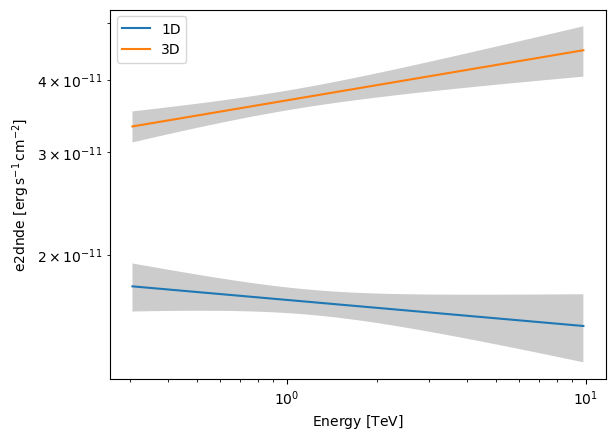

In [120]:
energy_bounds=[0.3, 10]*u.TeV
sed_type="e2dnde"

stacked.models[0].spectral_model.plot(energy_bounds=energy_bounds, sed_type=sed_type, label="1D")
stacked.models[0].spectral_model.plot_error(energy_bounds=energy_bounds, sed_type=sed_type)

spectral_model_3d.plot(energy_bounds=energy_bounds, sed_type=sed_type, label="3D")
spectral_model_3d.plot_error(energy_bounds=energy_bounds, sed_type=sed_type)

plt.legend()